__Skip Connection / Bottleneck Skip connection__

![image](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F99F0453F5C47F1741338F0)

- ResNet50 부터는 연산량의 줄이기 위해 Residual Block 내에, 1x1, 3x3, 1x1 컨볼루션 연산을 쌓았다. Inception에서 배웠던 것과 같은 개념이다. 1x1 컨볼루션 연산으로 피쳐맵의 갯수를 줄였다가 3x3을 거친 후, 1x1 컨볼루션 연산으로 차원을 늘려준다. 이 과정이 병목 같다 하여 병목레이어(bottleneck layer)라고 부른다.

__Residual Block / Identity Block__

![image](https://datascienceschool.net/upfiles/2e104ff279804e839cef46fc58ef16e7.png)

-  이미지가 반으로 작아진 경우, Identity Block이 사용되며, 입력값을 바로 더하지 않고, 1x1 컨볼루션 연산을 스트라이드 2로 설정하여 피쳐맵의 크기와 갯수를 맞추어준 다음 더해준다. 이를 프로젝션 숏컷(projection shortcut)

__ResNet Structrue by layer__

![image](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99167C335C47F0E315)

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# modules setting

import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
from utils import one_hot, train_valid_split, random_minibatch, shuffle
from utils import training_history

# Load Data

In [2]:
train_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/HHT/8ch/train'
npy_files = os.listdir(train_dir)
npy_files

['ball_7.npy',
 'ball_14.npy',
 'ball_21.npy',
 'inner_7.npy',
 'inner_14.npy',
 'inner_21.npy',
 'outer_7.npy',
 'outer_14.npy',
 'outer_21.npy',
 'normal.npy']

In [3]:
normal = np.load(os.path.join(train_dir, str([i for i in npy_files if 'normal' in i][0])))
ball_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_7' in i][0])))
ball_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_14' in i][0])))
ball_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_21' in i][0])))
inner_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_7' in i][0])))
inner_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_14' in i][0])))
inner_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_21' in i][0])))
outer_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_7' in i][0])))
outer_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_14' in i][0])))
outer_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_21' in i][0])))

normal_y = one_hot(normal, 0, nb_classes = 10)
ball_7_y = one_hot(ball_7, 1, nb_classes = 10)
ball_14_y = one_hot(ball_14, 2, nb_classes = 10)
ball_21_y = one_hot(ball_21, 3, nb_classes = 10)
inner_7_y = one_hot(inner_7, 4, nb_classes = 10)
inner_14_y = one_hot(inner_14, 5, nb_classes = 10)
inner_21_y = one_hot(inner_21, 6, nb_classes = 10)
outer_7_y = one_hot(outer_7, 7, nb_classes = 10)
outer_14_y = one_hot(outer_14, 8, nb_classes = 10)
outer_21_y = one_hot(outer_21, 9, nb_classes = 10)

print("normal:", normal.shape, normal_y.shape)
print("ball_7:", ball_7.shape, ball_7_y.shape)
print("ball_14:", ball_14.shape, ball_14_y.shape)
print("ball_21:", ball_21.shape, ball_21_y.shape)
print("inner_7:", inner_7.shape, inner_7_y.shape)
print("inner_14:", inner_14.shape, inner_14_y.shape)
print("inner_21:", inner_21.shape, inner_21_y.shape)
print("outer_7:", outer_7.shape, outer_7_y.shape)
print("outer_14:", outer_14.shape, outer_14_y.shape)
print("outer_21:", outer_21.shape, outer_21_y.shape)

normal: (750, 100, 100, 8) (750, 10)
ball_7: (750, 100, 100, 8) (750, 10)
ball_14: (750, 100, 100, 8) (750, 10)
ball_21: (750, 100, 100, 8) (750, 10)
inner_7: (750, 100, 100, 8) (750, 10)
inner_14: (750, 100, 100, 8) (750, 10)
inner_21: (750, 100, 100, 8) (750, 10)
outer_7: (750, 100, 100, 8) (750, 10)
outer_14: (750, 100, 100, 8) (750, 10)
outer_21: (750, 100, 100, 8) (750, 10)


# Data split

In [4]:
normal_train_x, normal_train_y, normal_valid_x, normal_valid_y = train_valid_split(normal, normal_y)
print("normal:", normal_train_x.shape, normal_train_y.shape, normal_valid_x.shape, normal_valid_y.shape)

ball_7_train_x, ball_7_train_y, ball_7_valid_x, ball_7_valid_y = train_valid_split(ball_7, ball_7_y)
ball_14_train_x, ball_14_train_y, ball_14_valid_x, ball_14_valid_y = train_valid_split(ball_14, ball_14_y)
ball_21_train_x, ball_21_train_y, ball_21_valid_x, ball_21_valid_y = train_valid_split(ball_21, ball_21_y)
print("ball_7:", ball_7_train_x.shape, ball_7_train_y.shape, ball_7_valid_x.shape, ball_7_valid_y.shape)
print("ball_14:", ball_14_train_x.shape, ball_14_train_y.shape, ball_14_valid_x.shape, ball_14_valid_y.shape)
print("ball_21:", ball_21_train_x.shape, ball_21_train_y.shape, ball_21_valid_x.shape, ball_21_valid_y.shape)

inner_7_train_x, inner_7_train_y, inner_7_valid_x, inner_7_valid_y = train_valid_split(inner_7, inner_7_y)
inner_14_train_x, inner_14_train_y, inner_14_valid_x, inner_14_valid_y = train_valid_split(inner_14, inner_14_y)
inner_21_train_x, inner_21_train_y, inner_21_valid_x, inner_21_valid_y = train_valid_split(inner_21, inner_21_y)
print("inner_7:", inner_7_train_x.shape, inner_7_train_y.shape, inner_7_valid_x.shape, inner_7_valid_y.shape)
print("inner_14:", inner_14_train_x.shape, inner_14_train_y.shape, inner_14_valid_x.shape, inner_14_valid_y.shape)
print("inner_21:", inner_21_train_x.shape, inner_21_train_y.shape, inner_21_valid_x.shape, inner_21_valid_y.shape)

outer_7_train_x, outer_7_train_y, outer_7_valid_x, outer_7_valid_y = train_valid_split(outer_7, outer_7_y)
outer_14_train_x, outer_14_train_y, outer_14_valid_x, outer_14_valid_y = train_valid_split(outer_14, outer_14_y)
outer_21_train_x, outer_21_train_y, outer_21_valid_x, outer_21_valid_y = train_valid_split(outer_21, outer_21_y)
print("outer_7:", outer_7_train_x.shape, outer_7_train_y.shape, outer_7_valid_x.shape, outer_7_valid_y.shape)
print("outer_14:", outer_14_train_x.shape, outer_14_train_y.shape, outer_14_valid_x.shape, outer_14_valid_y.shape)
print("outer_21:", outer_21_train_x.shape, outer_21_train_y.shape, outer_21_valid_x.shape, outer_21_valid_y.shape)

normal: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
ball_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
inner_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_7: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_14: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)
outer_21: (638, 100, 100, 8) (638, 10) (112, 100, 100, 8) (112, 10)


In [5]:
train_X = np.vstack([normal_train_x, ball_7_train_x, ball_14_train_x, ball_21_train_x, 
                     inner_7_train_x, inner_14_train_x, inner_21_train_x,
                     outer_7_train_x, outer_14_train_x, outer_21_train_x, ])
train_Y = np.vstack([normal_train_y, ball_7_train_y, ball_14_train_y, ball_21_train_y, 
                     inner_7_train_y, inner_14_train_y, inner_21_train_y,
                     outer_7_train_y, outer_14_train_y, outer_21_train_y, ])
valid_X = np.vstack([normal_valid_x, ball_7_valid_x, ball_14_valid_x, ball_21_valid_x, 
                     inner_7_valid_x, inner_14_valid_x, inner_21_valid_x,
                     outer_7_valid_x, outer_14_valid_x, outer_21_valid_x, ])
valid_Y = np.vstack([normal_valid_y, ball_7_valid_y, ball_14_valid_y, ball_21_valid_y, 
                     inner_7_valid_y, inner_14_valid_y, inner_21_valid_y,
                     outer_7_valid_y, outer_14_valid_y, outer_21_valid_y, ])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (6380, 100, 100, 8) (6380, 10)
Validation set: (1120, 100, 100, 8) (1120, 10)


In [6]:
noise_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/HHT/8ch_noisy/train'
npy_files = os.listdir(noise_dir)
npy_files

['minus4.npy',
 'minus4_y.npy',
 'minus2.npy',
 'minus2_y.npy',
 '0.npy',
 '0_y.npy',
 '2.npy',
 '2_y.npy',
 '4.npy',
 '4_y.npy',
 '6.npy',
 '6_y.npy',
 '8.npy',
 '8_y.npy',
 '10.npy',
 '10_y.npy']

In [7]:
noise_10_x, noise_10_y = np.load(noise_dir + '/10.npy'), np.load(noise_dir + '/10_y.npy')
noise_8_x, noise_8_y = np.load(noise_dir + '/8.npy'), np.load(noise_dir + '/8_y.npy')
noise_6_x, noise_6_y = np.load(noise_dir + '/6.npy'), np.load(noise_dir + '/6_y.npy')

print(noise_10_x.shape, noise_10_y.shape)
print(noise_8_x.shape, noise_8_y.shape)
print(noise_6_x.shape, noise_6_y.shape)

noise_X = np.vstack([noise_10_x, noise_8_x, noise_6_x])
noise_Y = np.vstack([noise_10_y, noise_8_y, noise_6_y])

# noise_X = np.concatenate((noise_10_x, noise_8_x), axis =0)
# noise_Y = np.concatenate((noise_10_y, noise_8_y), axis =0)

print(noise_X.shape, noise_Y.shape)

(800, 100, 100, 8) (800, 10)
(800, 100, 100, 8) (800, 10)
(800, 100, 100, 8) (800, 10)
(2400, 100, 100, 8) (2400, 10)


In [8]:
train_noise_X, train_noise_Y, valid_noise_X, valid_noise_Y = train_valid_split(noise_X, noise_Y)

print("Noise data")
print("Training set:", train_noise_X.shape, train_noise_Y.shape)
print("Validation set:", valid_noise_X.shape, valid_noise_Y.shape)

Noise data
Training set: (2040, 100, 100, 8) (2040, 10)
Validation set: (360, 100, 100, 8) (360, 10)


# Model

In [9]:
input_h = 100
input_w = 100
input_ch = 8

ch = 16
# 50 50 16

r_ch_1 = 32
# 25 25 32

r_ch_2 = 32
# 12 12 16

r_ch_3 = 64
# 12 12 32

r_ch_4 = 128
# 6 6 128

n_output = 10

In [10]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
batch_prob = tf.placeholder(tf.bool, name = 'bn_prob')

class ResNet50:
    def __init__(self, ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4):
        self.ch = ch
        self.r_ch_1 = r_ch_1
        self.r_ch_2 = r_ch_2
        self.r_ch_3 = r_ch_3
        self.r_ch_4 = r_ch_4
    def conv(self, x, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        conv = tf.layers.conv2d(inputs = x, filters = channel, kernel_size = kernel_size, 
                                strides = strides, padding = "SAME")
        conv = tf.layers.batch_normalization(conv, center=True, scale=True, training=batch_prob)
        if activation == True:
            conv = tf.nn.relu(conv)
        return conv
    
    def maxp(self, conv):
        maxp = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2)
        return maxp

    def res_block(self, x, channel):
        x_shortcut = x
        conv_a = self.conv(x, channel/4, kernel_size = [1, 1])
        conv_b = self.conv(conv_a, channel/4, kernel_size = [3, 3])
        conv_c = self.conv(conv_b, channel, kernel_size = [1, 1])
        return tf.nn.relu(conv_c + x_shortcut)
    
    def id_block(self, x, channel, strides = (2, 2)):
        x_shortcut = x
        conv_2a = self.conv(x, channel/4, kernel_size = [1, 1], strides = strides)
        conv_2b = self.conv(conv_2a, channel/4, kernel_size = [3, 3])
        conv_2c = self.conv(conv_2b, channel, kernel_size = [1, 1], activation = False)
        conv_1 = self.conv(x, channel, kernel_size = [1, 1], strides = strides, activation = False)
        return tf.nn.relu(conv_1 + conv_2c)

    def fc_layer(self, gap, n_output = None):
        flatten = tf.layers.flatten(gap)
        output = tf.layers.dense(inputs = flatten, units = n_output)
        return output

    def global_avg_pooling(self, x):
        gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        return gap

    def res_block_rep(self, x, target_ch, n_rep):
        for _ in range(n_rep):
            x = self.res_block(x, target_ch)
        return x

    def inf(self, x):
        """
        conv_1: 1
        id_~ + resnet_~: 16 x 3 = 48
        fc_lay: 1

        total: 50
        """
        conv_1 = self.conv(x, self.ch, strides = (2, 2))
        maxp_1 = self.maxp(conv_1)
        id_1 = self.id_block(maxp_1, self.r_ch_1, strides = (1, 1))
        res_1 = self.res_block_rep(id_1, self.r_ch_1, n_rep = 2)
        id_2 = self.id_block(res_1,self.r_ch_2, strides = (2, 2))
        res_2 = self.res_block_rep(id_2, self.r_ch_2, n_rep = 3)
        id_3 = self.id_block(res_2, self.r_ch_3, strides = (2, 2))
        res_3 = self.res_block_rep(id_3, self.r_ch_3, n_rep = 5)
        id_4 = self.id_block(res_3, self.r_ch_4, strides = (2, 2))
        res_4 = self.res_block_rep(id_4, self.r_ch_4, n_rep = 2)
        gap = self.global_avg_pooling(res_4)
        score = self.fc_layer(gap, n_output)
        return score

    
model = ResNet50(ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1215 17:53:40.648096 140437284222720 deprecation.py:323] From <ipython-input-10-f95364146dc4>:16: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1215 17:53:40.657884 140437284222720 deprecation.py:506] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1215 17:53:40.862434 140437284222720 deprecation.py:323] From <ipython-input-10-f95364146dc4>:17: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_d

# Training

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 0.00 %    || 3.12 %    || 2.43056202 || 2.34712601
--------------------------------------------------------------
[*200] || 18.75 %    || 10.94 %    || 2.27898312 || 2.43919063
--------------------------------------------------------------


W1215 17:54:43.373066 140437284222720 deprecation.py:323] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*300] || 25.00 %    || 18.75 %    || 2.22264624 || 2.12604141
--------------------------------------------------------------
[*400] || 56.25 %    || 34.38 %    || 1.27932191 || 1.54668546
--------------------------------------------------------------
[*500] || 37.50 %    || 53.12 %    || 1.32267010 || 1.24940801
--------------------------------------------------------------
[*600] || 62.50 %    || 73.44 %    || 1.10717797 || 0.78139436
--------------------------------------------------------------
[*700] || 68.75 %    || 62.50 %    || 0.88502651 || 0.93767095
--------------------------------------------------------------
[*800] || 81.25 %    || 76.56 %    || 0.62229550 || 0.67035288
--------------------------------------------------------------
[*900] || 81.25 %    || 74.22 %    || 0.31415117 || 0.64507246
--------------------------------------------------------------
[1000] || 62.50 %    || 82.81 %    || 0.63233238 || 0.47409511
-------------------------------------------------------

[6800] || 100.00 %    || 100.00 %    || 0.00149662 || 0.00274081
--------------------------------------------------------------
[6900] || 100.00 %    || 99.22 %    || 0.01415902 || 0.01577316
--------------------------------------------------------------
[7000] || 100.00 %    || 100.00 %    || 0.00067348 || 0.00288911
--------------------------------------------------------------
[7100] || 100.00 %    || 100.00 %    || 0.00067668 || 0.01110569
--------------------------------------------------------------
[7200] || 100.00 %    || 100.00 %    || 0.00068255 || 0.00474827
--------------------------------------------------------------
[7300] || 100.00 %    || 100.00 %    || 0.00103682 || 0.00344968
--------------------------------------------------------------
[7400] || 100.00 %    || 100.00 %    || 0.00038311 || 0.00620117
--------------------------------------------------------------
[7500] || 100.00 %    || 100.00 %    || 0.00559403 || 0.00148599
----------------------------------------

[13200] || 100.00 %    || 100.00 %    || 0.00018463 || 0.00025751
--------------------------------------------------------------
[13300] || 100.00 %    || 100.00 %    || 0.00019643 || 0.00036551
--------------------------------------------------------------
[13400] || 100.00 %    || 100.00 %    || 0.00130095 || 0.00366754
--------------------------------------------------------------
[13500] || 100.00 %    || 100.00 %    || 0.00021027 || 0.00015425
--------------------------------------------------------------
[13600] || 100.00 %    || 100.00 %    || 0.00013585 || 0.00041562
--------------------------------------------------------------
[13700] || 100.00 %    || 100.00 %    || 0.00009429 || 0.00022875
--------------------------------------------------------------
[13800] || 100.00 %    || 100.00 %    || 0.00040050 || 0.00089204
--------------------------------------------------------------
[13900] || 100.00 %    || 100.00 %    || 0.00010957 || 0.00111509
-------------------------------

[19600] || 100.00 %    || 100.00 %    || 0.00030965 || 0.00017362
--------------------------------------------------------------
[19700] || 100.00 %    || 100.00 %    || 0.00012092 || 0.00007017
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00007953 || 0.00004469
--------------------------------------------------------------
[19900] || 100.00 %    || 99.22 %    || 0.00017625 || 0.02981950
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00005614 || 0.00009584
--------------------------------------------------------------
[20100] || 100.00 %    || 100.00 %    || 0.00017735 || 0.00021412
--------------------------------------------------------------
[20200] || 100.00 %    || 100.00 %    || 0.00011029 || 0.00009110
--------------------------------------------------------------
[20300] || 100.00 %    || 100.00 %    || 0.00011167 || 0.00018300
--------------------------------

[26000] || 100.00 %    || 100.00 %    || 0.00012847 || 0.00395548
--------------------------------------------------------------
[26100] || 100.00 %    || 100.00 %    || 0.00063781 || 0.00062039
--------------------------------------------------------------
[26200] || 100.00 %    || 100.00 %    || 0.00006600 || 0.00014053
--------------------------------------------------------------
[26300] || 100.00 %    || 100.00 %    || 0.00002500 || 0.00023953
--------------------------------------------------------------
[26400] || 100.00 %    || 100.00 %    || 0.00003795 || 0.00012604
--------------------------------------------------------------
[26500] || 100.00 %    || 99.22 %    || 0.00003934 || 0.00878919
--------------------------------------------------------------
[26600] || 100.00 %    || 100.00 %    || 0.00001440 || 0.00015582
--------------------------------------------------------------
[26700] || 100.00 %    || 100.00 %    || 0.00002318 || 0.00006973
--------------------------------

[32400] || 100.00 %    || 100.00 %    || 0.00001993 || 0.00010102
--------------------------------------------------------------
[32500] || 100.00 %    || 100.00 %    || 0.00000718 || 0.00002178
--------------------------------------------------------------
[32600] || 100.00 %    || 100.00 %    || 0.00001340 || 0.00004456
--------------------------------------------------------------
[32700] || 100.00 %    || 100.00 %    || 0.00004932 || 0.00001924
--------------------------------------------------------------
[32800] || 100.00 %    || 100.00 %    || 0.00000739 || 0.00001601
--------------------------------------------------------------
[32900] || 100.00 %    || 100.00 %    || 0.00001518 || 0.00001824
--------------------------------------------------------------
[33000] || 100.00 %    || 100.00 %    || 0.00001869 || 0.00001606
--------------------------------------------------------------
[33100] || 100.00 %    || 100.00 %    || 0.00000627 || 0.00007462
-------------------------------

[38800] || 100.00 %    || 100.00 %    || 0.00000677 || 0.00509461
--------------------------------------------------------------
[38900] || 100.00 %    || 100.00 %    || 0.00000974 || 0.00002426
--------------------------------------------------------------
[39000] || 100.00 %    || 100.00 %    || 0.00000463 || 0.00276700
--------------------------------------------------------------
[39100] || 100.00 %    || 100.00 %    || 0.00002006 || 0.00028487
--------------------------------------------------------------
[39200] || 100.00 %    || 100.00 %    || 0.00000558 || 0.00002107
--------------------------------------------------------------
[39300] || 100.00 %    || 100.00 %    || 0.00032239 || 0.00018694
--------------------------------------------------------------
[39400] || 100.00 %    || 100.00 %    || 0.00007012 || 0.00017690
--------------------------------------------------------------
[39500] || 100.00 %    || 99.22 %    || 0.00000839 || 0.05731389
--------------------------------

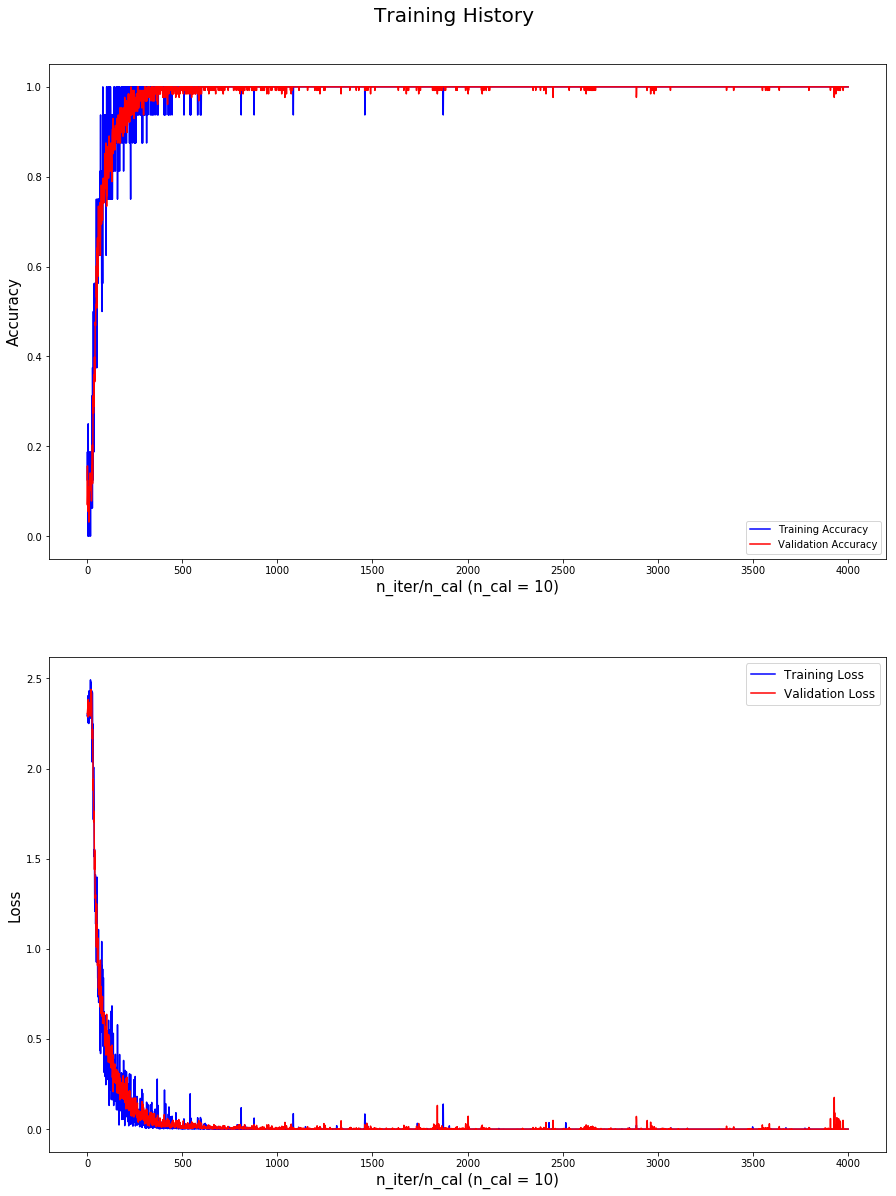

In [11]:
t_batch = 8
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)
lr = 1e-4

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# optm = tf.train.AdamOptimizer(lr).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
early_stopping = False

hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
    train_n_x, train_n_y = random_minibatch(train_noise_X, train_noise_Y, batch_size = t_batch)
    
    train_x, train_y = np.concatenate((train_x, train_n_x), axis = 0), np.concatenate((train_y, train_n_y), axis = 0)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
        valid_n_x, valid_n_y = random_minibatch(valid_noise_X, valid_noise_Y, batch_size = v_batch)
        valid_x, valid_y = np.concatenate((valid_x, valid_n_x), axis = 0), np.concatenate((valid_y, valid_n_y), axis = 0)
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'bn_prob:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'hht_8ch_n6_res50_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/HHT/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_HHT_8ch_n6_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_HHT_8ch_n6_loss', np.array(loss_train))

hist.plot(n_cal)   

# sess.close()